# Notebook 02 - Preprocessing & Feature Engineering

**Objective:** Clean, filter, merge all three raw datasets and create features for modeling.

---

**Preprocessing:**
1. Load & parse JSON columns in all 3 datasets
2. Type conversions, drop corrupted rows (non-numeric IDs)
3. Remove duplicates from all 3 datasets
4. Filter: Released status, budget > 0, revenue > 0, vote_count > 0
5. Inner-join all 3 datasets on `id`

**Feature Engineering:**
6. Binary: `is_collection`, `is_english`
7. Temporal: `release_year`, `release_month`
8. Financial: `roi` (replaces raw revenue)
9. Counts: `num_genres`, `num_keywords`, `num_cast`, `num_crew`, etc.
10. `primary_genre` categorical
11. Top modern directors & actors (post-2010) binary features
12. Drop unused columns, save processed data

In [20]:
# 1. Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from ast import literal_eval
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print('Libraries loaded')

Libraries loaded


In [21]:
# Load all three raw datasets
movies_df = pd.read_csv('../data/raw/movies_metadata.csv', low_memory=False)
credits_df = pd.read_csv('../data/raw/credits.csv')
keywords_df = pd.read_csv('../data/raw/keywords.csv')

print(f'movies_metadata : {movies_df.shape[0]:,} rows x {movies_df.shape[1]} cols')
print(f'credits         : {credits_df.shape[0]:,} rows x {credits_df.shape[1]} cols')
print(f'keywords        : {keywords_df.shape[0]:,} rows x {keywords_df.shape[1]} cols')

movies_metadata : 45,466 rows x 24 cols
credits         : 45,476 rows x 3 cols
keywords        : 46,419 rows x 2 cols


In [22]:
# JSON parser for stringified list-of-dicts columns
def parse_json_column(val):
    if pd.isna(val):
        return []
    if isinstance(val, str):
        try:
            return json.loads(val)
        except Exception:
            try:
                parsed = literal_eval(val)
                return parsed if isinstance(parsed, list) else []
            except Exception:
                return []
    return val if isinstance(val, list) else []

# Parse movies JSON columns
print('Parsing JSON columns...')
for col in ['genres', 'production_companies', 'production_countries', 'spoken_languages']:
    movies_df[col] = movies_df[col].apply(parse_json_column)

# Parse credits JSON columns
credits_df['cast_parsed'] = credits_df['cast'].apply(parse_json_column)
credits_df['crew_parsed'] = credits_df['crew'].apply(parse_json_column)

# Parse keywords
keywords_df['keywords_parsed'] = keywords_df['keywords'].apply(parse_json_column)

print('Done')

Parsing JSON columns...
Done


---
## 2. Cleaning & Filtering

In [23]:
# 2.1  Type conversions + drop corrupted rows
n_start = len(movies_df)
print(f'Starting rows: {n_start:,}')

# Drop rows with non-numeric IDs (3 corrupted rows found in EDA)
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df = movies_df.dropna(subset=['id'])
movies_df['id'] = movies_df['id'].astype(int)

# Convert numeric columns stored as strings
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')
movies_df['runtime'] = pd.to_numeric(movies_df['runtime'], errors='coerce')
movies_df['vote_average'] = pd.to_numeric(movies_df['vote_average'], errors='coerce')
movies_df['vote_count'] = pd.to_numeric(movies_df['vote_count'], errors='coerce')

# Parse release date
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

n_after = len(movies_df)
print(f'After type cleanup: {n_after:,}  (dropped {n_start - n_after:,} corrupted rows)')

Starting rows: 45,466
After type cleanup: 45,463  (dropped 3 corrupted rows)


In [24]:
# 2.2  Remove duplicates from all 3 datasets
print('--- Removing duplicates ---')

n1 = len(movies_df)
movies_df = movies_df.drop_duplicates(subset=['id'], keep='first')
print(f'Movies:   {n1:,} -> {len(movies_df):,}  (dropped {n1 - len(movies_df):,})')

n2 = len(credits_df)
credits_df = credits_df.drop_duplicates(subset=['id'], keep='first')
print(f'Credits:  {n2:,} -> {len(credits_df):,}  (dropped {n2 - len(credits_df):,})')

n3 = len(keywords_df)
keywords_df = keywords_df.drop_duplicates(subset=['id'], keep='first')
print(f'Keywords: {n3:,} -> {len(keywords_df):,}  (dropped {n3 - len(keywords_df):,})')

--- Removing duplicates ---
Movies:   45,463 -> 45,433  (dropped 30)
Credits:  45,476 -> 45,432  (dropped 44)
Keywords: 46,419 -> 45,432  (dropped 987)


In [25]:
# 2.3  Filter movies
print('--- Filtering movies ---')
print(f'Start: {len(movies_df):,}')

# Keep only Released movies
movies_df = movies_df[movies_df['status'] == 'Released']
print(f'After status=Released: {len(movies_df):,}')

# Remove movies with budget <= 0 or revenue <= 0 (corrupted/missing financial data)
movies_df = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]
print(f'After budget>0 & revenue>0: {len(movies_df):,}')

# Remove entries with 0 vote_count
movies_df = movies_df[movies_df['vote_count'] > 0]
print(f'After vote_count>0: {len(movies_df):,}')

# Handle runtime: drop zeros, fill NaN with median
movies_df = movies_df[movies_df['runtime'] > 0]
med_runtime = movies_df['runtime'].median()
movies_df['runtime'] = movies_df['runtime'].fillna(med_runtime)
print(f'After valid runtime: {len(movies_df):,}')

# Drop missing release dates
movies_df = movies_df.dropna(subset=['release_date'])
print(f'Final after all filters: {len(movies_df):,}')

--- Filtering movies ---
Start: 45,433
After status=Released: 44,985
After budget>0 & revenue>0: 5,371
After vote_count>0: 5,364
After valid runtime: 5,352
Final after all filters: 5,352


---
## 3. Merge All Datasets

In [26]:
# 3.1  Inner join all 3 datasets on 'id'
credits_merge = credits_df[['id', 'cast_parsed', 'crew_parsed']].copy()
keywords_merge = keywords_df[['id', 'keywords_parsed']].copy()

# Ensure integer IDs for clean merge
credits_merge['id'] = pd.to_numeric(credits_merge['id'], errors='coerce')
credits_merge = credits_merge.dropna(subset=['id'])
credits_merge['id'] = credits_merge['id'].astype(int)

keywords_merge['id'] = pd.to_numeric(keywords_merge['id'], errors='coerce')
keywords_merge = keywords_merge.dropna(subset=['id'])
keywords_merge['id'] = keywords_merge['id'].astype(int)

df = movies_df.merge(credits_merge, on='id', how='inner')
df = df.merge(keywords_merge, on='id', how='inner')

lost = len(movies_df) - len(df)
print(f'Merged dataset: {len(df):,} rows x {df.shape[1]} cols')
print(f'Movies lost in merge: {lost:,}')

Merged dataset: 5,352 rows x 27 cols
Movies lost in merge: 0


---
## 4. Feature Engineering

In [27]:
# 4.1  Binary features

# belongs_to_collection -> binary (is the movie part of a franchise?)
df['is_collection'] = df['belongs_to_collection'].apply(
    lambda x: 0 if pd.isna(x) or x == '' else 1)
n_coll = df['is_collection'].sum()
print(f'is_collection: {n_coll:,} / {len(df):,} movies in a franchise')

# original_language -> is_english
df['is_english'] = (df['original_language'] == 'en').astype(int)
n_en = df['is_english'].sum()
pct = df['is_english'].mean() * 100
print(f'is_english: {n_en:,} / {len(df):,} ({pct:.1f}%)')

is_collection: 1,220 / 5,352 movies in a franchise
is_english: 4,783 / 5,352 (89.4%)


In [28]:
# 4.2  Temporal features
df['release_year'] = df['release_date'].dt.year.astype(int)
df['release_month'] = df['release_date'].dt.month.astype(int)

yr_min = int(df['release_year'].min())
yr_max = int(df['release_year'].max())
print(f'Release year range: {yr_min} - {yr_max}')
print()
print('Most common release months:')
print(df['release_month'].value_counts().head(5).to_string())

Release year range: 1915 - 2017

Most common release months:
release_month
9     622
12    553
10    494
8     472
6     457


In [29]:
# 4.3  Financial feature: ROI
# ROI = (revenue - budget) / budget * 100
# Replaces raw revenue. Budget is KEPT as an input feature (production scale matters).
df['roi'] = ((df['revenue'] - df['budget']) / df['budget'] * 100).round(2)

roi_med = df['roi'].median()
roi_mean = df['roi'].mean()
n_profit = (df['roi'] > 0).sum()
pct_profit = n_profit / len(df) * 100
print(f'ROI: median={roi_med:.1f}%, mean={roi_mean:.1f}%')
print(f'Profitable movies (ROI > 0): {n_profit:,} / {len(df):,} ({pct_profit:.1f}%)')

# Drop revenue column (encoded in ROI). Keep budget as input feature.
df = df.drop(columns=['revenue'])
print('Dropped revenue column (encoded in ROI)')

ROI: median=106.7%, mean=559504.6%
Profitable movies (ROI > 0): 3,743 / 5,352 (69.9%)
Dropped revenue column (encoded in ROI)


In [30]:
# 4.4  Count features
df['num_genres'] = df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_keywords'] = df['keywords_parsed'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_cast'] = df['cast_parsed'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_crew'] = df['crew_parsed'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)

count_cols = ['num_genres', 'num_keywords', 'num_cast', 'num_crew',
              'num_production_companies', 'num_production_countries', 'num_spoken_languages']
print('Count feature statistics:')
print(df[count_cols].describe().round(1).to_string())

Count feature statistics:
       num_genres  num_keywords  num_cast  num_crew  num_production_companies  num_production_countries  num_spoken_languages
count      5352.0        5352.0    5352.0    5352.0                    5352.0                    5352.0                5352.0
mean          2.6           8.1      23.9      29.4                       2.9                       1.4                   1.5
std           1.1           6.2      20.6      33.1                       2.2                       0.8                   0.9
min           0.0           0.0       0.0       0.0                       0.0                       0.0                   0.0
25%           2.0           4.0      12.0       9.0                       1.0                       1.0                   1.0
50%           3.0           7.0      18.0      17.0                       2.0                       1.0                   1.0
75%           3.0          11.0      27.0      35.0                       4.0               

In [31]:
# 4.5  Primary genre (first listed genre)
def get_primary_genre(genres_list):
    if isinstance(genres_list, list) and len(genres_list) > 0:
        return genres_list[0].get('name', 'Unknown')
    return 'Unknown'

df['primary_genre'] = df['genres'].apply(get_primary_genre)
n_genres = df['primary_genre'].nunique()
print(f'Unique primary genres: {n_genres}')
print()
print(df['primary_genre'].value_counts().to_string())

Unique primary genres: 21

primary_genre
Drama              1306
Comedy             1061
Action              958
Adventure           413
Horror              325
Crime               265
Thriller            199
Animation           146
Fantasy             140
Romance             121
Science Fiction     104
Mystery              67
Family               55
Documentary          46
War                  38
Music                34
Western              31
History              29
Unknown               9
Foreign               4
TV Movie              1


In [34]:
# 4.6  Top modern directors (post-2010) - binary feature
# Directors still active in recent years are more relevant for prediction

# Extract all (director, year) pairs from merged data
dir_year_pairs = []
for _, row in df.iterrows():
    year = row['release_year']
    crew = row['crew_parsed']
    if isinstance(crew, list):
        for m in crew:
            if isinstance(m, dict) and m.get('job') == 'Director' and m.get('name'):
                dir_year_pairs.append((m['name'], year))

dir_year_df = pd.DataFrame(dir_year_pairs, columns=['director', 'year'])

# Top 50 directors by post-2010 movie count
post2010_dirs = dir_year_df[dir_year_df['year'] >= 2010]['director'].value_counts()
top_directors = set(post2010_dirs.head(50).index)
n_top = len(top_directors)
print(f'Top {n_top} modern directors (by post-2010 movies):')
print(post2010_dirs.head(10).to_string())

# Binary feature: does this movie have a top modern director?
def has_top_dir(crew):
    if not isinstance(crew, list):
        return 0
    for m in crew:
        if isinstance(m, dict) and m.get('job') == 'Director':
            if m.get('name', '') in top_directors:
                return 1
    return 0

df['has_top_director'] = df['crew_parsed'].apply(has_top_dir)
n_td = df['has_top_director'].sum()
pct_td = df['has_top_director'].mean() * 100
print(f'Movies with top director: {n_td:,} ({pct_td:.1f}%)')

Directors with >= 3 post-2010 movies: 123

--- Top 15 by MEAN ROI (min 3 movies) ---
          director  num_movies    mean_roi  median_roi
    Ariel Schulman           4 4293.055000     3385.22
       Henry Joost           4 4293.055000     3385.22
         James Wan           4 2526.655000     1523.29
    James DeMonaco           3 1690.733333     1108.70
M. Night Shyamalan           4 1261.455000      990.67
        Tom Hooper           3 1204.543333      624.28
     Pierre Coffin           4 1125.812500     1176.20
        Kyle Balda           3 1012.190000     1175.08
      Chris Renaud           4  832.660000      877.49
 John Erick Dowdle           3  642.070000      702.00
       John Madden           4  520.812500      443.98
    S.S. Rajamouli           3  517.496667      224.71
 Steven Soderbergh           5  508.460000      111.24
    Gareth Edwards           3  469.100000      428.03
   Lasse Hallström           5  457.702000      359.91

--- Top 15 by MOVIE COUNT (for com

In [35]:
# 4.7  Top modern actors (post-2010) - binary features

# Extract all (actor, year, order) triples
act_data = []
for _, row in df.iterrows():
    year = row['release_year']
    cast = row['cast_parsed']
    if isinstance(cast, list):
        for m in cast:
            if isinstance(m, dict) and m.get('name') and 'order' in m:
                act_data.append((m['name'], year, m['order']))

act_df = pd.DataFrame(act_data, columns=['actor', 'year', 'order'])
post2010_acts = act_df[act_df['year'] >= 2010]

# Top 50 actors + top 50 lead actors (order=0) by post-2010 count
top_actors = set(post2010_acts['actor'].value_counts().head(50).index)
top_leads = set(post2010_acts[post2010_acts['order'] == 0]['actor'].value_counts().head(50).index)

print(f'Top 50 modern actors sample: {list(top_actors)[:5]}')
print(f'Top 50 modern leads sample: {list(top_leads)[:5]}')

# Binary features
def count_top_actors(cast):
    if not isinstance(cast, list):
        return 0
    return sum(1 for m in cast if isinstance(m, dict) and m.get('name', '') in top_actors)

def check_top_lead(cast):
    if not isinstance(cast, list):
        return 0
    for m in cast:
        if isinstance(m, dict) and m.get('order') == 0:
            if m.get('name', '') in top_leads:
                return 1
    return 0

df['has_top_actor'] = df['cast_parsed'].apply(lambda x: 1 if count_top_actors(x) > 0 else 0)
df['top_actor_count'] = df['cast_parsed'].apply(count_top_actors)
df['has_top_lead_actor'] = df['cast_parsed'].apply(check_top_lead)

n_ta = df['has_top_actor'].sum()
n_tl = df['has_top_lead_actor'].sum()
avg_tc = df['top_actor_count'].mean()
pct_ta = df['has_top_actor'].mean() * 100
pct_tl = df['has_top_lead_actor'].mean() * 100
print(f'has_top_actor: {n_ta:,} ({pct_ta:.1f}%)')
print(f'has_top_lead_actor: {n_tl:,} ({pct_tl:.1f}%)')
print(f'Mean top actors per movie: {avg_tc:.2f}')

Actors with >= 3 post-2010 movies: 3240

--- Top 15 Actors by MEAN ROI ---
            actor  num_movies     mean_roi
     Boris Kodjoe           3 3.333352e+07
   Michael Eklund           4 2.500003e+07
   Katrina Bowden           6 1.666685e+07
   Martin Donovan           6 1.666669e+07
Nicholas D'Agosto           3 8.960698e+05
   Alexa PenaVega           4 6.720687e+05
  Adriana Barraza           4 6.720512e+05
     Choi Min-sik           3 7.428865e+04
   Alexis Denisof           3 4.621520e+04
      Mandy Moore           3 4.617729e+04
     Jane Seymour           3 4.588329e+04
     Richard Reid           4 3.439144e+04
     Colleen Camp           5 2.790628e+04
     James Brolin           5 2.771526e+04
    Jessica Szohr           6 2.304547e+04

--- Top 15 Lead Actors by MEAN ROI (order=0, min 3 leads) ---
               actor  num_leads    mean_roi
       Casey Affleck          3 5393.696667
   Katie Featherston          3 4195.836667
      Patrick Wilson          4 2329.99250

---
## 5. Drop Unused Columns & Final Cleanup

In [36]:
# 5.1  Drop raw/unused columns
drop_cols = [
    'adult', 'video', 'status',
    'belongs_to_collection', 'homepage', 'tagline', 'poster_path',
    'imdb_id', 'original_title', 'overview',
    'original_language', 'release_date',
    'genres', 'production_companies', 'production_countries', 'spoken_languages',
    'cast_parsed', 'crew_parsed', 'keywords_parsed',
]

# Only drop columns that still exist
drop_cols = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=drop_cols)

print(f'Dropped {len(drop_cols)} columns')
print(f'Final shape: {len(df):,} rows x {df.shape[1]} cols')
print()
print('Remaining columns:')
for i, col in enumerate(df.columns):
    print(f'  {i+1:2d}. {col}')

Dropped 19 columns
Final shape: 5,352 rows x 24 cols

Remaining columns:
   1. budget
   2. id
   3. popularity
   4. runtime
   5. title
   6. vote_average
   7. vote_count
   8. is_collection
   9. is_english
  10. release_year
  11. release_month
  12. roi
  13. num_genres
  14. num_keywords
  15. num_cast
  16. num_crew
  17. num_production_companies
  18. num_production_countries
  19. num_spoken_languages
  20. primary_genre
  21. has_top_director
  22. has_top_actor
  23. top_actor_count
  24. has_top_lead_actor


In [37]:
# 5.2  Final dataset overview
print('=' * 80)
print('FINAL PROCESSED DATASET')
print('=' * 80)
print(f'Shape: {len(df):,} rows x {df.shape[1]} columns')
print()
print('--- Data Types ---')
print(df.dtypes.to_string())
print()
print('--- Numeric Summary ---')
numeric_df = df.select_dtypes(include=[np.number])
print(numeric_df.describe().round(2).to_string())
print()
print('--- Missing Values ---')
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing.to_string())
else:
    print('None!')

FINAL PROCESSED DATASET
Shape: 5,352 rows x 24 columns

--- Data Types ---
budget                        int64
id                            int64
popularity                  float64
runtime                     float64
title                           str
vote_average                float64
vote_count                  float64
is_collection                 int64
is_english                    int64
release_year                  int64
release_month                 int64
roi                         float64
num_genres                    int64
num_keywords                  int64
num_cast                      int64
num_crew                      int64
num_production_companies      int64
num_production_countries      int64
num_spoken_languages          int64
primary_genre                   str
has_top_director              int64
has_top_actor                 int64
top_actor_count               int64
has_top_lead_actor            int64

--- Numeric Summary ---
             budget         id  popu

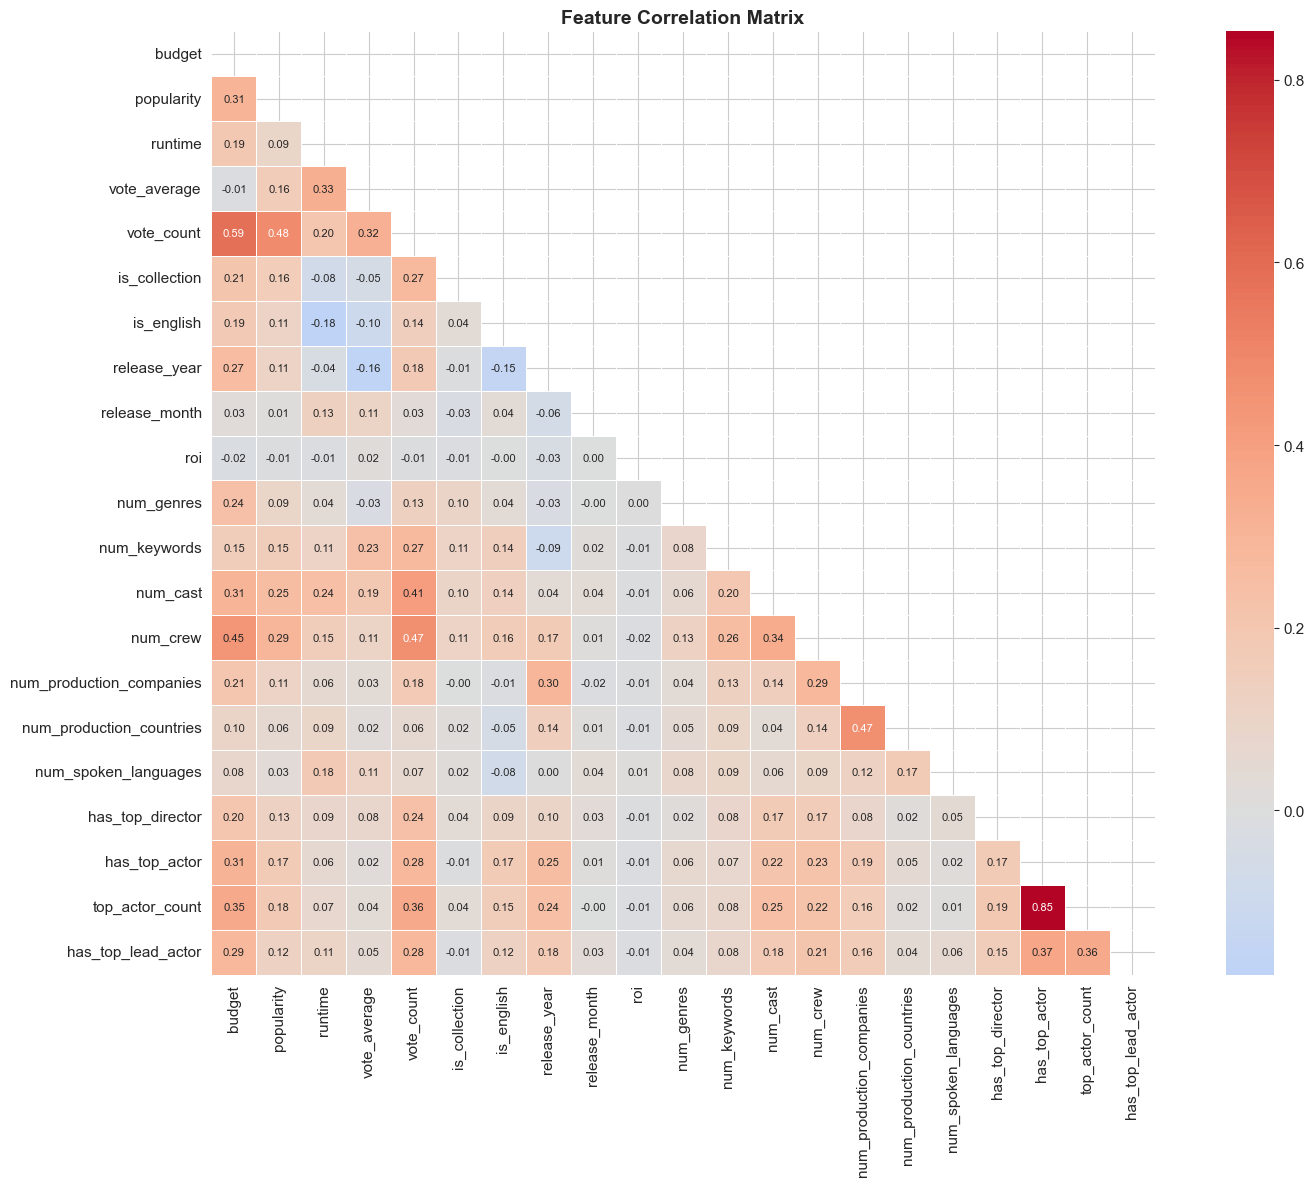

--- Correlations with ROI ---
vote_average                0.015833
num_spoken_languages        0.013422
num_genres                  0.002256
release_month               0.000736
is_english                 -0.002840
has_top_director           -0.008025
vote_count                 -0.008740
num_cast                   -0.008748
popularity                 -0.008748
num_keywords               -0.009657
num_production_companies   -0.010081
has_top_lead_actor         -0.010736
top_actor_count            -0.011695
num_production_countries   -0.011810
is_collection              -0.011842
has_top_actor              -0.013710
runtime                    -0.014386
num_crew                   -0.015594
budget                     -0.019967
release_year               -0.034802


In [17]:
# 5.3  Correlation heatmap of final features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove 'id' from correlation (it's just a reference)
if 'id' in numeric_features:
    numeric_features.remove('id')

corr = df[numeric_features].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            mask=mask, square=True, linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key correlations with ROI
print('--- Correlations with ROI ---')
roi_corr = corr['roi'].drop('roi').sort_values(ascending=False)
print(roi_corr.to_string())

In [18]:
# 6. Save processed dataset
os.makedirs('../data/processed', exist_ok=True)
output_path = '../data/processed/movies_processed.csv'
df.to_csv(output_path, index=False)
print(f'Saved {len(df):,} rows x {df.shape[1]} cols to {output_path}')
print()
print('Columns saved:')
for i, col in enumerate(df.columns):
    dtype = str(df[col].dtype)
    print(f'  {i+1:2d}. {col:30s} {dtype}')

Saved 5,352 rows x 24 cols to ../data/processed/movies_processed.csv

Columns saved:
   1. budget                         int64
   2. id                             int64
   3. popularity                     float64
   4. runtime                        float64
   5. title                          str
   6. vote_average                   float64
   7. vote_count                     float64
   8. is_collection                  int64
   9. is_english                     int64
  10. release_year                   int64
  11. release_month                  int64
  12. roi                            float64
  13. num_genres                     int64
  14. num_keywords                   int64
  15. num_cast                       int64
  16. num_crew                       int64
  17. num_production_companies       int64
  18. num_production_countries       int64
  19. num_spoken_languages           int64
  20. primary_genre                  str
  21. has_top_director               int64
  22. 

---
## Summary

### Preprocessing Applied
| Step | Action | Effect |
|---|---|---|
| Type cleanup | Convert budget, revenue, popularity to numeric | Fixed string types |
| Corrupted rows | Drop non-numeric IDs | Removed 3 rows |
| Duplicates | Drop duplicate IDs in all 3 datasets | Clean unique entries |
| Status filter | Keep only Released movies | Drop unreleased/rumored |
| Financial filter | Require budget > 0 AND revenue > 0 | Drop entries with missing financial data |
| Vote filter | Require vote_count > 0 | Drop unrated movies |
| Runtime | Drop runtime <= 0 | Remove invalid entries |
| Merge | Inner join movies + credits + keywords on id | Combined dataset |

### Features Created
| Feature | Type | Description |
|---|---|---|
| `roi` | float | (revenue - budget) / budget * 100 |
| `is_collection` | binary | Movie belongs to a franchise/collection |
| `is_english` | binary | Original language is English |
| `release_year` | int | Year of release |
| `release_month` | int | Month of release (1-12) |
| `num_genres` | int | Number of genres assigned |
| `num_keywords` | int | Number of keywords |
| `num_cast` | int | Cast size |
| `num_crew` | int | Crew size |
| `num_production_companies` | int | Number of production companies |
| `num_production_countries` | int | Number of production countries |
| `num_spoken_languages` | int | Number of spoken languages |
| `primary_genre` | categorical | First listed genre |
| `has_top_director` | binary | Director is in top 50 modern (post-2010) |
| `has_top_actor` | binary | Any cast member is top 50 modern actor |
| `top_actor_count` | int | How many top actors in cast |
| `has_top_lead_actor` | binary | Lead (order=0) is a top 50 modern lead actor |

### Next Steps
- **Notebook 03:** Prepare for modeling - encode `primary_genre`, feature selection, scaling, train/test split